In [1]:
# DATA2001 Assessment
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Data2001 Assignment

## Data Cleaning and Data loading

### Connecting to Server.

In [1]:
import os
import json

import pandas as pd
from sqlalchemy import *
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras


def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

#login to database
db,conn = pgconnect("Credentials.json")

Connected successfully.


## 1. Loading csvs

### Loading neighbourhoods.csv

In [2]:
Neighbourhoods = pd.read_csv('Neighbourhoods.csv')
Neighbourhoods = Neighbourhoods.dropna()
Neighbourhoods = Neighbourhoods.drop_duplicates(subset=['area_id'])
Neighbourhoods.to_sql("NeighbourhoodsTable", con=conn, if_exists='replace', index=False)

### Loading BusinessStats.csv

In [3]:
import pandas as pd

data_path  = globals()['_dh'][0]

file_names = ['BusinessStats.csv']
business_stats_schema = """CREATE TABLE IF NOT EXISTS BusinessStatsTable (
                         area_id         INT PRIMARY KEY UNIQUE,
                         area_name         VARCHAR(50),
                         business_count       INT,
                         accommodation_and_food_services_count   INT,
                         retail_trade_count   INT,
                         agriculture_forestry_and_fishing_count INT,
                         health_care_and_social_assistance_count INT,
                         public_administration_and_safety_count INT,
                         transport_postal_and_warehousing_count INT
                   )"""

loaded_data = pd.read_csv(os.path.join(data_path,file_names[0]))
loaded_data.drop_duplicates()

conn.execute("DROP TABLE IF EXISTS BusinessStatsTable")
conn.execute(business_stats_schema)

for index,row in loaded_data.iterrows():
    placeholders = ",".join(["%s"]*(len(row)))
    insert_stmt = "INSERT INTO BusinessStatsTable VALUES ( {} )".format(placeholders)
    conn.execute(insert_stmt,list(row))

InternalError: (psycopg2.errors.DependentObjectsStillExist) cannot drop table businessstatstable because other objects depend on it
DETAIL:  constraint sa2_statistical_areas_sa2_maincode_fkey on table sa2_statistical_areas depends on table businessstatstable
HINT:  Use DROP ... CASCADE to drop the dependent objects too.

[SQL: DROP TABLE IF EXISTS BusinessStatsTable]
(Background on this error at: http://sqlalche.me/e/2j85)

### loading SA2.shp

In [4]:
import geopandas as gpd
import os

# data_path  = globals()['_dh'][0]  
statistical_areas = gpd.read_file( os.path.join(data_path, "SA2_2016_AUST.shp") )
statistical_areas.dropna()
print(list(statistical_areas.iterrows())[0])
sa2 = '''CREATE TABLE IF NOT EXISTS sa2_statistical_areas (
                     sa2_maincode INT,
                     sa2_5digitcode INT,
                     sa2_name16  TEXT,
                     sa3_code16 INT,
                     sa3_name16 TEXT,
                     sa4_code TEXT,
                     sa4_name TEXT,
                     gccsa_code TEXT,
                     gccsa_name TEXT,
                     state_code INT,
                     state_name TEXT,
                     area_in_sqkm NUMERIC,
                     geom GEOMETRY(MULTIPOLYGON, 4283))''' 

conn.execute("DROP TABLE IF EXISTS sa2_statistical_areas")
conn.execute(sa2)

for index,row in statistical_areas.iterrows():
    if None in list(row):
        continue
    p = ",".join(["%s"]*(len(row)-1))
    g_p =  "ST_Multi(ST_GeomFromText(%s, 4283))"
    insert_stmt = "INSERT INTO sa2_statistical_areas VALUES ( {},{} )".format(p,g_p)
    conn.execute(insert_stmt,list(row[:-1])+[row[-1].wkt])

(0, SA2_MAIN16                                            101021007
SA2_5DIG16                                                11007
SA2_NAME16                                            Braidwood
SA3_CODE16                                                10102
SA3_NAME16                                           Queanbeyan
SA4_CODE16                                                  101
SA4_NAME16                                       Capital Region
GCC_CODE16                                                1RNSW
GCC_NAME16                                          Rest of NSW
STE_CODE16                                                    1
STE_NAME16                                      New South Wales
AREASQKM16                                              3418.35
geometry      POLYGON ((149.5842329970001 -35.44426999899997...
Name: 0, dtype: object)


### Load BreakEnterDwelling.shp

In [5]:
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

break_Enter = '''CREATE TABLE BreakEnter (
                     OBJECTID INT,
                     Contour NUMERIC,
                     Density  TEXT,
                     ORIG_FID INT,
                     Shape_Leng NUMERIC,
                     Shape_Area NUMERIC,
                     geom GEOMETRY(MULTIPOLYGON, 4283))
                     ''' 

conn.execute("DROP TABLE IF EXISTS BreakEnter")
conn.execute(break_Enter)

breakenter = gpd.read_file("BreakEnterDwelling_JanToDec2021.shp")
breakenter = breakenter.dropna()

for index,row in breakenter.iterrows():
    p = ",".join(["%s"] * (len(row)-1) )
    g_p =  "ST_Multi(ST_GeomFromText(%s, 4283))"
    insert_stmt = "INSERT INTO BreakEnter VALUES ( {},{} );".format(p,g_p)
    conn.execute(insert_stmt,list(row[:-1])+[row[-1].wkt])

### Load school.shp

In [6]:
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

school_schema = '''CREATE TABLE School (
                     USE_ID INT,
                     CATCH_TYPE TEXT,
                     USE_DESC  TEXT,
                     ADD_DATE INT,
                     KINDERART TEXT,
                     YEAR1 TEXT,
                     YEAR2 TEXT,
                     YEAR3 TEXT,
                     YEAR4 TEXT,
                     YEAR5 TEXT,
                     YEAR6 TEXT,
                     YEAR7 TEXT,
                     YEAR8 TEXT,
                     YEAR9 TEXT,
                     YEAR10 TEXT,
                     YEAR11 TEXT,
                     YEAR12 TEXT,
                     PRIORITY TEXT,
                     geom GEOMETRY(MULTIPOLYGON, 4283))
                     ''' 

conn.execute("DROP TABLE IF EXISTS School")
conn.execute(school_schema)        
        
school = gpd.read_file("catchments_secondary.shp")
school = school.append(gpd.read_file("catchments_primary.shp"))
school = school.append(gpd.read_file("catchments_future.shp"))
for index,row in school.iterrows():
    p = ",".join(["%s"]*(len(row)-1))
    g_p =  "ST_Multi(ST_GeomFromText(%s, 4283))"
    
    insert_stmt = "INSERT INTO school VALUES ( {},{} );".format(p,g_p)
    conn.execute(insert_stmt,list(row[:-1])+[row[-1].wkt])

### Creating foreign keys for neighbourhoodsTable and sa2_table referencing businessstatstable on area_id

In [7]:
conn.execute('''ALTER TABLE "NeighbourhoodsTable"
ADD FOREIGN KEY (area_id)
REFERENCES "businessstatstable" (area_id)
''')
conn.execute('''ALTER TABLE "sa2_statistical_areas"
ADD FOREIGN KEY (sa2_maincode)
REFERENCES "businessstatstable" (area_id)
''')

## 2. Livibility

### Creating indexes

In [9]:
conn.execute("""
CREATE INDEX school_index
   ON school
   USING GIST (geom);
""")
conn.execute("""
CREATE INDEX sa2_2016_aust_table_index
   ON sa2_statistical_areas
   USING GIST (geom);
""")
conn.execute("""
CREATE INDEX breakandenter_index
   ON breakEnter
   USING GIST (geom);
""")

ProgrammingError: (psycopg2.errors.DuplicateTable) relation "school_index" already exists

[SQL: 
CREATE INDEX school_index
   ON school
   USING GIST (geom);
]
(Background on this error at: http://sqlalche.me/e/f405)

### Creating indexes

In [10]:
import statistics
import numpy as np
import pandas as pd
from scipy.stats import spearmanr


reading_sql_data = """
    WITH Merge_Data AS (
    
        SELECT Neigh.area_id, Neigh.area_name, Neigh.land_area, to_number(Neigh.population,'999999')/1000 AS "population",
            Neigh.median_annual_household_income AS "income", Neigh.avg_monthly_rent AS "rent",
            ROUND(CAST(("0-4" + "5-9" +"10-14" + "15-19") AS numeric)/CAST(1000 AS numeric),3) AS "young_people", 
            b.accommodation_and_food_services_count AS "accom", b.retail_trade_count AS "retail",
            b.health_care_and_social_assistance_count AS "health", s.geom AS "area_geom", c.geom AS "school_geom"
        FROM "NeighbourhoodsTable" Neigh
        JOIN "businessstatstable" b ON(Neigh.area_id = b.area_id)
        JOIN "sa2_statistical_areas" s ON(Neigh.area_id = s.sa2_maincode) 
        FULL JOIN school c ON ST_Intersects(s.geom, c.geom)
        
    ), School_Counting AS ( -- Counting school geom
    
        SELECT area_id, area_name, land_area, population,
            income, rent, young_people, accom, retail,
            health,area_geom, COUNT("school_geom") AS "school_count"
        FROM Merge_Data
        GROUP BY (area_id, area_name, land_area,
            population, income, rent, young_people,
            accom, retail, health, area_geom)
    
    ), Final_Data AS ( -- Sum shape_area and add breakEnter (School_Counting)
    
        SELECT area_id, area_name, land_area AS "land_size", population,
            income,rent, young_people, accom, retail, health,
            school_count AS "Number_of_school", SUM(breakEnter.shape_area) AS "hotspot_area"
        FROM School_Counting 
        FULL JOIN breakEnter on ST_Intersects(School_Counting.area_geom, breakEnter.geom) 
        WHERE area_id IS NOT NULL
        GROUP BY (area_id, area_name, land_area, 
            population, income,rent, young_people,
            accom, retail, health, school_count)
    )
    
    SELECT * FROM Final_Data
"""

outcome = query(conn, reading_sql_data)

outcome['young_people'] = outcome['young_people'].fillna(0)

outcome['hotspot_area'] = outcome['hotspot_area'].fillna(0)

outcome['population'] = outcome['population'].fillna(0)

outcome['land_size'] = outcome['land_size'].fillna(0)

outcome


,area_id,area_name,land_size,population,income,rent,young_people,accom,retail,health,Number_of_school,hotspot_area
0,101051540,Goulburn Region,9035.1221,12.670,62712.0,800.0,3.090,38,52,33,39,0.000030
1,102011028,Avoca Beach - Copacabana,643.8000,7.590,46996.0,1906.0,2.214,33,35,60,6,0.000000
2,102011029,Box Head - MacMasters Beach,3208.6000,10.986,42621.0,1682.0,2.635,23,45,43,8,0.000034
3,102011030,Calga - Kulnura,76795.1000,4.841,42105.0,1182.0,1.098,14,43,12,27,0.000000
4,102011031,Erina - Green Point,3379.3000,14.237,43481.0,1595.0,3.227,68,145,179,17,0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,890.5000,22.084,55391.0,1947.0,6.210,52,84,92,16,0.000057
305,128021538,Sutherland - Kirrawee,775.5000,21.760,53378.0,1809.0,4.894,73,113,127,17,0.000374
306,128021607,Engadine,895.4000,17.424,52667.0,1955.0,5.176,37,69,82,13,0.000068
307,128021608,Loftus - Yarrawarrah,384.4000,7.426,51243.0,2163.0,2.054,9,20,25,8,0.000000


### Compute Livability Score

In [11]:
import numpy as np

def calcul_z_score(X):
    mu = X.mean()
    sigma = X.std()
    return (X - mu)/sigma


df = pd.DataFrame(columns = [])

df['Neighbourhoods'] = outcome['area_name']

df['income'] = outcome['income']

df['rent'] = outcome['rent']

df['z_school'] = calcul_z_score(outcome['Number_of_school']/outcome['young_people'])

df['z_accom'] = calcul_z_score(outcome['accom']/outcome['population'])

df['z_retail'] = calcul_z_score(outcome['retail']/outcome['population'])

df['z_crime'] = calcul_z_score(outcome['hotspot_area']/outcome['land_size'])

df['z_health'] = calcul_z_score(outcome['health']/outcome['population'])

# Use Sigmoid function
df['Sigmoid_Score'] = 1 / (1 + np.exp(-1 * (df['z_school'] + df['z_accom'] + df['z_retail'] - df['z_crime'] + df['z_health'])))

df


,Neighbourhoods,income,rent,z_school,z_accom,z_retail,z_crime,z_health,Sigmoid_Score
0,Goulburn Region,62712.0,800.0,0.160032,-0.226270,-0.359890,-0.475635,-0.740255,0.333867
1,Avoca Beach - Copacabana,46996.0,1906.0,-0.092028,0.140544,-0.263253,-0.476120,0.361358,0.650842
2,Box Head - MacMasters Beach,42621.0,1682.0,-0.083736,-0.472598,-0.361426,-0.474570,-0.468103,0.286735
3,Calga - Kulnura,42105.0,1182.0,0.464417,-0.255441,0.550609,-0.476120,-0.766389,0.615222
4,Erina - Green Point,43481.0,1595.0,-0.026973,0.257083,0.798755,-0.474986,1.331450,0.944554
...,...,...,...,...,...,...,...,...,...
304,Oyster Bay - Como - Jannali,55391.0,1947.0,-0.095424,-0.401588,-0.417154,-0.466691,-0.415763,0.296663
305,Sutherland - Kirrawee,53378.0,1809.0,-0.072608,-0.129558,-0.152413,-0.405541,-0.068588,0.495594
306,Engadine,52667.0,1955.0,-0.097074,-0.464456,-0.387353,-0.464940,-0.303486,0.312721
307,Loftus - Yarrawarrah,51243.0,2163.0,-0.061896,-0.712391,-0.628744,-0.476120,-0.581894,0.181116


### Preprocessing for computing correlations

In [12]:
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
corr_df = pd.DataFrame(columns = [])

corr_df['Neighbourhoods'] = df['Neighbourhoods']

corr_df['income'] = df['income']

corr_df['rent'] = df['rent']

corr_df['overall_score'] = df['Sigmoid_Score']

corr_df = corr_df.sort_values(['overall_score'], ascending=[False])

corr_df



,Neighbourhoods,income,rent,overall_score
89,Sydney - Haymarket - The Rocks,27311.0,2998.0,1.000000
268,Badgerys Creek,46021.0,553.0,1.000000
109,Chullora,41625.0,2280.0,0.999996
177,North Sydney - Lavender Bay,71668.0,2749.0,0.999857
93,Bondi Junction - Waverly,56457.0,2630.0,0.998432
...,...,...,...,...
245,Guildford West - Merrylands West,42581.0,1587.0,0.049936
87,Redfern - Chippendale,51347.0,2193.0,0.038245
101,Kensington (NSW),50113.0,2315.0,0.034911
290,Lurnea - Cartwright,40864.0,1217.0,0.034870


### Income correlations

In [13]:
from scipy.stats import spearmanr
import numpy as np
np.corrcoef(corr_df['overall_score'],corr_df['income'])[0,1]

0.22375898551846893

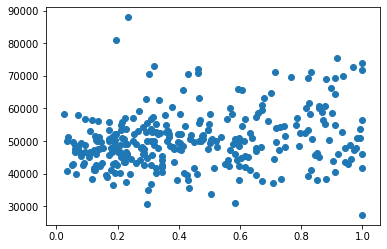

In [14]:
from matplotlib import pyplot

pyplot.scatter(corr_df['overall_score'],corr_df['income'])
pyplot.show()

### Rent correlations

In [15]:
np.corrcoef(corr_df['overall_score'],corr_df['rent'])[0,1]

0.4418631602254975

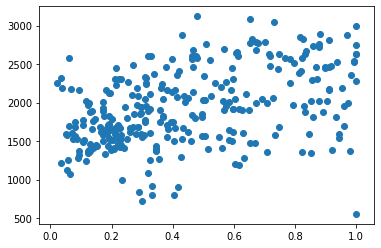

In [16]:
from matplotlib import pyplot

pyplot.scatter(corr_df['overall_score'],corr_df['rent'])
pyplot.show()

### Livability score visualisation

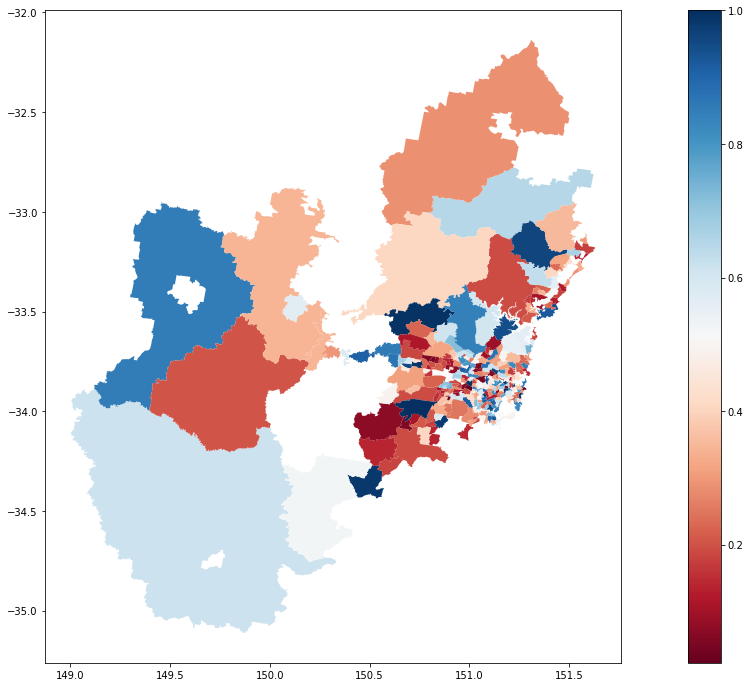

In [24]:
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from shapely import wkt
from shapely.wkt import loads
score = corr_df['overall_score']

neighbourhood = pd.read_sql_query('''SELECT ST_AsText(geom) AS ge
                                        FROM "NeighbourhoodsTable" Neigh
                                        JOIN "sa2_statistical_areas" s ON(Neigh.area_id = s.sa2_maincode) 
                                        ''', conn)

map_visualized = pd.DataFrame(
     {'score': score,
      'ge': neighbourhood['ge']
     })

map_visualized['ge'] = map_visualized['ge'].apply(wkt.loads)

g_map_visualized = gpd.GeoDataFrame(map_visualized, geometry='ge')

fig, ax = plt.subplots(1, figsize=(24,12))
g_map_visualized.plot(ax=ax,cmap = 'RdBu', column='score', legend=True)

## 3. City of Sydney Analysis

### Read in Greenhouse_gas_profile file

In [25]:
#11. JSON

import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

Greenhouse_gas_profile_schema = '''CREATE TABLE Greenhouse_gas_profile(
                     OBJECTID1 INT,
                     Area_suburb TEXT,
                     Data_Category  TEXT,
                     F2005_06 NUMERIC,
                     F2006_07 NUMERIC,
                     F2007_08 NUMERIC,
                     F2008_09 NUMERIC,
                     F2009_10 NUMERIC,
                     F2010_11 NUMERIC,
                     F2011_12 NUMERIC,
                     F2012_13 NUMERIC,
                     F2013_14 NUMERIC,
                     F2014_15 NUMERIC,
                     F2015_16 NUMERIC,
                     GF2016_17 NUMERIC,
                     F2017_18 NUMERIC,
                     GF2018_19 NUMERIC,
                     Shape__Area NUMERIC,
                     Shape__Length NUMERIC,
                     geometry GEOMETRY(MULTIPOLYGON, 4283))
                     ''' 

conn.execute("DROP TABLE IF EXISTS Greenhouse_gas_profile")
conn.execute(Greenhouse_gas_profile_schema)        
        
Greenhouse_gas_profile = gpd.read_file('Greenhouse_gas_profile.geojson')
for index,row in Greenhouse_gas_profile.iterrows():
    placeholders = ",".join(["%s"]*(len(row)-1))
    geom_col_placeholder =  "ST_Multi(ST_GeomFromText(%s, 4283))"  
    insert_stmt = "INSERT INTO Greenhouse_gas_profile VALUES ( {},{} );".format(placeholders,geom_col_placeholder)
    conn.execute(insert_stmt,list(row[:-1])+[row[-1].wkt])

### Read in Waste_generation file

In [26]:
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

Waste_generation_schema = '''CREATE TABLE Waste_generation(
                     OBJECTID1 INT,
                     Area_suburb TEXT,
                     Data_Type  TEXT,
                     F2005_06 NUMERIC,
                     F2006_07 NUMERIC,
                     F2007_08 NUMERIC,
                     F2008_09 NUMERIC,
                     F2009_10 NUMERIC,
                     F2010_11 NUMERIC,
                     F2011_12 NUMERIC,
                     F2012_13 NUMERIC,
                     F2013_14 NUMERIC,
                     F2014_15 NUMERIC,
                     F2015_16 NUMERIC,
                     WF2016_17 NUMERIC,
                     F2017_18 NUMERIC,
                     WF2018_19 NUMERIC,
                     Shape__Area NUMERIC,
                     Shape__Length NUMERIC,
                     geometry GEOMETRY(MULTIPOLYGON, 4283))
                     ''' 

conn.execute("DROP TABLE IF EXISTS Waste_generation")
conn.execute(Waste_generation_schema)        
        
Waste_generation = gpd.read_file('Waste_generation.geojson')
for index,row in Waste_generation.iterrows():
    placeholders = ",".join(["%s"]*(len(row)-1))
    geom_col_placeholder =  "ST_Multi(ST_GeomFromText(%s, 4283))"  
    insert_stmt = "INSERT INTO Waste_generation VALUES ( {},{} );".format(placeholders,geom_col_placeholder)
    conn.execute(insert_stmt,list(row[:-1])+[row[-1].wkt])

In [27]:
conn.execute("""
CREATE INDEX greengas_index
   ON Greenhouse_gas_profile
   USING GIST (geometry);
""")
conn.execute("""
CREATE INDEX waste_index
   ON Waste_generation
   USING GIST (geometry);
""")

### Spatial join greenhouse data and waste generation data with our previous dataframe obtained by joining all other data

In [28]:
import pandas as pd
import numpy as np

def calcul_z_score(X):
    mu = X.mean()
    sigma = X.std()
    return (X - mu)/sigma

reading_new_sql_data = """
    WITH Pollution AS (
        SELECT Area_suburb, w.WF2016_17, g.GF2016_17
        FROM "waste_generation" w JOIN "greenhouse_gas_profile" g USING(Area_suburb)
        GROUP BY (Area_suburb, w.WF2016_17, g.GF2016_17)
    )
    SELECT * FROM Pollution
"""

pollution = query(conn, reading_new_sql_data)
pollution["wf2016_17"] = pollution["wf2016_17"].fillna(0)
pollution["gf2016_17"] = pollution["gf2016_17"].fillna(0)

pollution_dict = dict()

tpath = "Waste_generation_by_suburb.shp"
green_shp_df = gpd.GeoDataFrame.from_file(tpath, encoding = 'gb18030')

for index,row in pollution.iterrows():
    try:
        try:
            waste_number = float(row[1])
        except:
            waste_number = 0
        gree_number = float(row[2])
    except:
        gree_number = 0
    
    for green_index, green_row in green_shp_df.iterrows():
        if (green_row["Area_subur"] == row[0]):
            green_geom = green_row["geometry"]
            break
    if row[0] not in pollution_dict:
        pollution_dict[row[0]] = [waste_number, gree_number, green_geom]
    else:
        pollution_dict[row[0]][0] += waste_number
        pollution_dict[row[0]][1] += gree_number

suburb_list = []
waste_list = []
green_list = []
geometry_list = []
for suburb in pollution_dict:
    suburb_list.append(suburb)
    waste_list.append(pollution_dict[suburb][0])
    green_list.append(pollution_dict[suburb][1])
    geometry_list.append(pollution_dict[suburb][2])
df_dict = {"Suburb": suburb_list, "Greenhouse gas emissions (tCO2e)": green_list, "Disposal & Recycling": waste_list, "Geometry": geometry_list}

pollution_df = pd.DataFrame(df_dict)
pollution_df

,Suburb,Greenhouse gas emissions (tCO2e),Disposal & Recycling,Geometry
0,Dawes Point,6.014037e+04,1.627103e+04,"POLYGON ((151.209737897194 -33.854217563259, 1..."
1,Darlinghurst,7.021584e+05,1.702367e+05,"POLYGON ((151.213511976621 -33.8738651495059, ..."
2,Pyrmont,1.113215e+06,1.851252e+05,"POLYGON ((151.198059311614 -33.8685830439687, ..."
3,Darlington,1.840481e+05,3.268041e+04,"POLYGON ((151.198868267883 -33.8886349351668, ..."
4,Erskineville,1.877664e+05,5.166805e+04,"POLYGON ((151.189100065637 -33.8982137245485, ..."
5,Potts Point,3.535407e+05,1.278098e+05,"POLYGON ((151.227482549868 -33.8680623056097, ..."
6,Redfern,4.128173e+05,1.082467e+05,"POLYGON ((151.201828912939 -33.88909999799, 15..."
7,Millers Point + Barangaroo,1.655561e+05,2.576996e+04,"POLYGON ((151.204668817233 -33.8566326897134, ..."
8,Beaconsfield,3.929537e+04,2.019131e+04,"POLYGON ((151.202837749749 -33.9087357492586, ..."
9,Chippendale,2.629162e+05,4.161672e+04,"POLYGON ((151.206251518508 -33.8855154540904, ..."


### Compute the overall sigmoid score when we take all the factors into account(z_score of greenhouse and z_score of waste generation and others)

In [29]:
df_list = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
i = 0
for area_name in outcome['area_name']:
    j = 0
    for suburb in pollution_df['Suburb']:
        if 'North Sydney' in area_name:
            continue
        if suburb in area_name:
            df_list[0].append(outcome["area_name"][i])
            df_list[1].append(outcome["land_size"][i])
            df_list[2].append(outcome["population"][i])
            df_list[3].append(outcome["income"][i])
            df_list[4].append(outcome["rent"][i])
            df_list[5].append(outcome["young_people"][i])
            df_list[6].append(outcome["accom"][i])
            df_list[7].append(outcome["retail"][i])
            df_list[8].append(outcome["health"][i])
            df_list[9].append(outcome["Number_of_school"][i])
            df_list[10].append(outcome["hotspot_area"][i])
            df_list[11].append(pollution_df["Greenhouse gas emissions (tCO2e)"][j])
            df_list[12].append(pollution_df["Disposal & Recycling"][j])
            df_list[13].append(pollution_df["Suburb"][j])
            df_list[14].append(pollution_df["Geometry"][j])
        j += 1
    i += 1

pollution_zip = zip(df_list[0], df_list[1], df_list[2], df_list[3], df_list[4], df_list[5], df_list[6], df_list[7], df_list[8], df_list[9], df_list[10], df_list[11], df_list[12], df_list[13], df_list[14])

final_pollution_df = pd.DataFrame((pollution_zip), columns = ["area_name", "land_size", "population", "income", "rent", "young_people", "accom", "retail", "health", "Number_of_school", "hotspot_area", "Greenhouse gas emissions (tCO2e)", "Disposal & Recycling","Suburb", "Geometry"])

final_pollution_df
polu_df = pd.DataFrame(columns = [])

polu_df['suburb'] = final_pollution_df["Suburb"]

polu_df['geometry'] = final_pollution_df["Geometry"]

polu_df['z_school'] = calcul_z_score(final_pollution_df['Number_of_school']/final_pollution_df['young_people'])

polu_df['z_accom'] = calcul_z_score(final_pollution_df['accom']/final_pollution_df['population'])

polu_df['z_retail'] = calcul_z_score(final_pollution_df['retail']/final_pollution_df['population'])

polu_df['z_crime'] = calcul_z_score(final_pollution_df['hotspot_area']/final_pollution_df['land_size'])

polu_df['z_health'] = calcul_z_score(final_pollution_df['health']/final_pollution_df['population'])

polu_df['z_green'] = calcul_z_score(final_pollution_df["Greenhouse gas emissions (tCO2e)"])

polu_df['z_waste'] = calcul_z_score(final_pollution_df["Disposal & Recycling"])

# Use Sigmoid function
polu_df['Sigmoid_Score'] = 1 / (1 + np.exp(-1 * (polu_df['z_school'] + polu_df['z_accom'] + polu_df['z_retail'] - polu_df['z_crime'] + polu_df['z_health'] - polu_df['z_green'] + polu_df['z_waste'])))

polu_df = polu_df.sort_values(['Sigmoid_Score'], ascending=[False])

polu_df

,suburb,geometry,z_school,z_accom,z_retail,z_crime,z_health,z_green,z_waste,Sigmoid_Score
15,Haymarket,"POLYGON ((151.209083421509 -33.8797971179927, ...",-0.320429,2.144367,2.137518,-0.902431,2.035694,0.024718,0.043204,0.999011
14,The Rocks,"POLYGON ((151.209804657291 -33.8610304051708, ...",-0.320429,2.144367,2.137518,-0.902431,2.035694,-0.271866,-0.265298,0.998999
13,Sydney,"POLYGON ((151.209083422407 -33.8797971187385, ...",-0.320429,2.144367,2.137518,-0.902431,2.035694,3.932664,3.812587,0.998864
0,Darlinghurst,"POLYGON ((151.213511976621 -33.8738651495059, ...",2.878278,-0.018547,-0.245811,2.708118,0.690548,-0.120378,-0.111020,0.646961
12,Surry Hills,"POLYGON ((151.218188802721 -33.8850630076007, ...",1.384519,-0.045671,-0.172608,1.134723,-0.208188,0.037673,0.159802,0.486368
2,Alexandria,"POLYGON ((151.19913442343 -33.8951673712459, 1...",-0.632445,-0.461369,-0.103063,-0.858512,-0.620796,0.014950,0.717883,0.436291
17,Paddington,"POLYGON ((151.233086037591 -33.8897546950578, ...",-0.187030,-0.582092,-0.283510,-0.761057,-0.193454,-0.435406,-0.522615,0.360721
4,Darlington,"POLYGON ((151.198868267883 -33.8886349351668, ...",-0.291668,-0.488074,-0.586210,-0.591639,-0.070302,-0.426066,-0.506483,0.283934
1,Erskineville,"POLYGON ((151.189100065637 -33.8982137245485, ...",-0.632445,-0.461369,-0.103063,-0.858512,-0.620796,-0.423872,-0.451895,0.271469
5,Camperdown,"POLYGON ((151.187046079418 -33.884749461485, 1...",-0.291668,-0.488074,-0.586210,-0.591639,-0.070302,-0.117441,-0.308207,0.262042


### Visualisation of combined livability scores for all inner City Suburb in Sydney

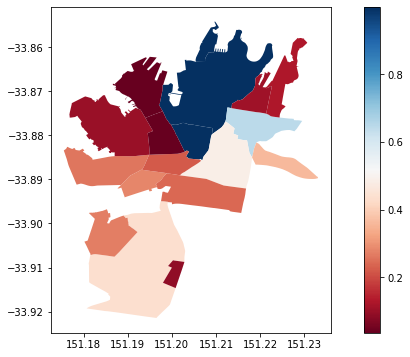

In [30]:
tpath = "Waste_generation_by_suburb.shp"
green_shp_df = gpd.GeoDataFrame.from_file(tpath, encoding = 'gb18030')
green_shp_df

score = polu_df['Sigmoid_Score']

polu_df['geometry'] = polu_df['geometry'].astype(str)
pollu_grom = polu_df['geometry']
map_visualized = pd.DataFrame(
     {'score': score,
      'po': pollu_grom
     })


map_visualized['po'] = map_visualized['po'].apply(wkt.loads)

g_map_visualized = gpd.GeoDataFrame(map_visualized, geometry = 'po')

fig, ax = plt.subplots(1, figsize=(12,6))
g_map_visualized.plot(ax=ax,cmap = 'RdBu', column='score', legend = True)


### Close connection

In [197]:
conn.close()
db.dispose()